# Introduction

This notebook is focused on getting a feel for the Perceptron.  This is similar information to the very nice [webpage](http://sebastianraschka.com/Articles/2015_singlelayer_neurons.html) by Sebastian Raschka, which has very good graphics. He covers all this material much better there, although his code is Python instead of Julia.  As with the other notebooks in this series, I hope it helps people get a better feel for using the [Julia](http://julialang.org/) programming language.

This notebook was originally designed as an adjunct to a [talk I gave](https://www.meetup.com/Monterey-Bay-Data-Science-Meetup/events/241814181/) on Aug 3rd, 2017 at [CSUMB](https://csumb.edu/) introducing neural networks.

# Perceptron 

The **Perceptron** is the basic building block of a neural network, first described by Frank Rosenblatt in his 1957 paper, *The Perceptron--a perceiving and recognizing automaton*. It was conceived as a system that could take input and learn patterns through supervision. A single layer perceptron is able to learn any linearly separable pattern.

We will use it to linearly separate categories of flowers from the famous Iris dataset, based on the variables petal length and petal width.


## Get the data

Those with an R background are likely familiar with the Iris dataset.  Several popular R datasets are available in Julia through the `RDatasets` library.  To use dataframes in Julia, we have to import the library.

In [1]:
using DataFrames;
using RDatasets;
iris = dataset("datasets", "iris")

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Categorical…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


## Peek at data

In [2]:
size(iris)

(150, 5)

In [3]:
# the `by` function allows examining a dataframe by a category variable
by(iris, :Species, nrow)

,Species,x1
,Categorical…,Int64
1,setosa,50
2,versicolor,50
3,virginica,50


In [4]:
# Julia uses `describe` to get a summary of basic statistics
describe(iris)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,SepalLength,5.84333,4.3,5.8,7.9,,,Float64
2,SepalWidth,3.05733,2.0,3.0,4.4,,,Float64
3,PetalLength,3.758,1.0,4.35,6.9,,,Float64
4,PetalWidth,1.19933,0.1,1.3,2.5,,,Float64
5,Species,,setosa,,virginica,3,,CategoricalString{UInt8}


In [5]:
# load plotting libraries
using Plots
using StatsPlots
gr(size=(800,600))

Plots.GRBackend()

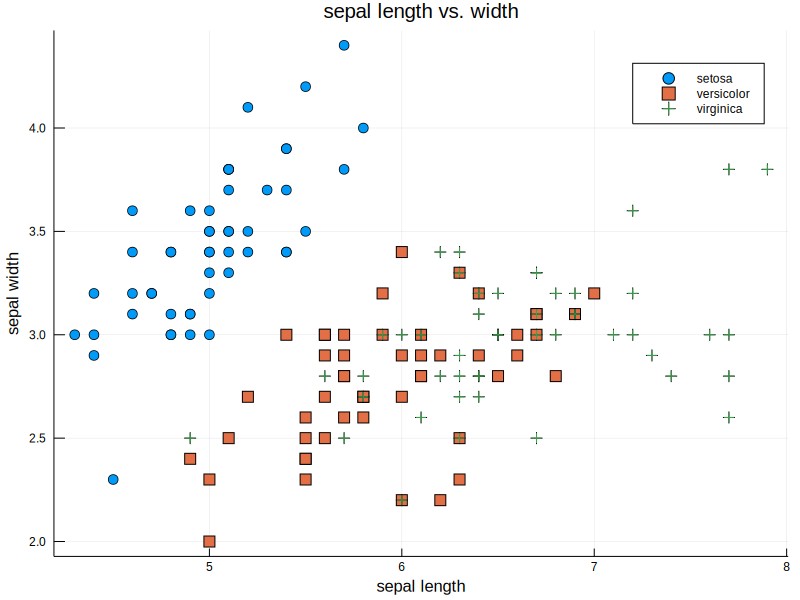

In [6]:
@df iris scatter(:SepalLength, :SepalWidth, group=:Species, title = "sepal length vs. width", 
xlabel = "sepal length", ylabel = "sepal width", marker=([:circle :rect :cross], 5))

So, there are 150 data points, with 50 of each species.  Using a perceptron, we are going to try to find the linear separation between setosa and non-setosa, using sepal length and sepal width.  

## The equations

![Perceptron](http://sebastianraschka.com/images/blog/2015/singlelayer_neural_networks_files/perceptron_schematic.png) Image by Sebastian Raschka from his [article](http://sebastianraschka.com/Articles/2015_singlelayer_neurons.html) as mentioned above.  

For all $N$ dimensions $i$,

$$\quad\mathbf{w} ^\intercal \mathbf{x}= \sum_{i=1}^N w_ix_i + w_0$$

where $x$ is the input data and $w$ is the weight with $w_0$ as a bias term that is not multiplied by an input.

Squash output for each sample j,
$$\quad y_j = \begin{cases}\;1  \text{ if} \; \mathbf{w} ^\intercal \mathbf{x} \ge 0 \\
-1  \text{ otherwise} \end{cases}$$
and that produces the output.


**To learn**, we update weights ($w_j$) for data at $j$ based on their difference with the target,
$$\quad \Delta w_j = \eta \,(target^{(j)} - output^{(j)}) \,x_i^{(j)}$$

$\eta$ is the learning rate in the range 0 to 1.  target is the desired output, and output is $y_j$ calculated above.

In a two dimensional case,
$$\quad \Delta w_0 = \eta \,(target^{(0)} - output^{(0)})$$
$$\quad \Delta w_1 = \eta \,(target^{(1)} - output^{(1)})\,x_1^{(1)}$$
$$\quad \Delta w_2 = \eta \,(target^{(2)} - output^{(2)})\,x_2^{(2)}$$

Output and targets are always either 1 or -1, so weight update is 0 if they are the same, and $2\,\eta$ or $-2\,\eta$ if they are different.

### implementation
We will implement the algorithm step by step to see what the data looks like, then implement it in a loop to see how many iterations it takes to converge.

In [7]:
# create targets
@time target = [s=="setosa" ? 1 : -1 for s in iris[!, :Species]]

  0.056790 seconds (86.78 k allocations: 4.260 MiB)


150-element Array{Int64,1}:
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  ⋮
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1

For our data, we have two inputs corresponding to $x_1$ and $x_2$ in the equations above (sepal length and sepal width).  To create our data input array, we add a third column of 1's for the bias corresponding to $x_0$ above.

In [8]:
# to create input data array X, append a third column of 1's for the bias
@time X = hcat(iris[!, :SepalLength], iris[!, :SepalWidth], ones(150))

  0.090995 seconds (225.17 k allocations: 10.939 MiB)


150×3 Array{Float64,2}:
 5.1  3.5  1.0
 4.9  3.0  1.0
 4.7  3.2  1.0
 4.6  3.1  1.0
 5.0  3.6  1.0
 5.4  3.9  1.0
 4.6  3.4  1.0
 5.0  3.4  1.0
 4.4  2.9  1.0
 4.9  3.1  1.0
 5.4  3.7  1.0
 4.8  3.4  1.0
 4.8  3.0  1.0
 ⋮            
 6.0  3.0  1.0
 6.9  3.1  1.0
 6.7  3.1  1.0
 6.9  3.1  1.0
 5.8  2.7  1.0
 6.8  3.2  1.0
 6.7  3.3  1.0
 6.7  3.0  1.0
 6.3  2.5  1.0
 6.5  3.0  1.0
 6.2  3.4  1.0
 5.9  3.0  1.0

In [9]:
# initialize weights w as small random numbers
@time w = rand(3).-0.5

  0.142377 seconds (280.16 k allocations: 14.394 MiB, 5.88% gc time)


3-element Array{Float64,1}:
 -0.1433228879296975 
 -0.18853306630207456
  0.08275253506495628

In [13]:
# calculate output (predicted y) from the product X*w, and squash
@time output = [o >= 0 ? 1 : -1 for o in X*w]

  0.048003 seconds (63.95 k allocations: 3.180 MiB)


150-element Array{Int64,1}:
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
  ⋮
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1

If you look at the equations, $\Delta w_0$ is simply multiplied by each of the members of our input X to get the weight changes.

$$\quad \Delta w_0 = \eta \,(target^{(0)} - output^{(0)})$$
$$\quad \Delta w_1 = \eta \,(target^{(1)} - output^{(1)})\,x_1^{(1)}$$
$$\quad \Delta w_2 = \eta \,(target^{(2)} - output^{(2)})\,x_2^{(2)}$$

means

$$\quad \Delta w_0 = \eta \,(target^{(0)} - output^{(0)})$$
$$\quad \Delta w_1 = \eta \,(\Delta w_0)\,x_1^{(1)}$$
$$\quad \Delta w_2 = \eta \,(\Delta w_0)\,x_2^{(2)}$$

In [14]:
# calculate delta Δw0
η = 0.1
@time delta = η*(target.-output)

  0.000031 seconds (8 allocations: 2.859 KiB)


150-element Array{Float64,1}:
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [15]:
error = count(x->x!=0, delta)/150

0.3333333333333333

In [16]:
@time [sum((X.*delta)[:,i]) for i in 1:3]

  0.243195 seconds (451.46 k allocations: 22.256 MiB, 4.16% gc time)


3-element Array{Float64,1}:
 50.06             
 34.28             
 10.000000000000002

In [17]:
# Julia has a cumsum function which is a bit more efficient
@time cumsum(X.*delta, dims=1)[end,:]

  0.162345 seconds (318.11 k allocations: 16.164 MiB)


3-element Array{Float64,1}:
 50.06000000000001 
 34.28             
  9.999999999999996

### loop with learning rate η = 0.1

In [20]:
# put into loop and save weights and errors for plotting, η = 0.1
epochs = 30
w = rand(3).-0.5
η = 0.1
errors = Float64[]
weights = Array{Float64}(undef,epochs,3)
for i in 1:epochs
    output = [o >= 0 ? 1 : -1 for o in X*w]
    delta = η*(target.-output)
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[i,:] = w
    push!(errors, count(x->x!=0, delta)/150)
end
errors

30-element Array{Float64,1}:
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.66                
 0.3333333333333333  
 0.3333333333333333  
 ⋮                   
 0.013333333333333334
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667
 0.013333333333333334
 0.006666666666666667
 0.02                

In [21]:
weights

30×3 Array{Float64,2}:
   49.841      34.2869    10.4568  
  -75.399     -23.1531    -9.54317 
  -25.339      11.1269     0.456828
   24.721      45.4069    10.4568  
 -100.519     -12.0331    -9.54317 
  -50.459      22.2469     0.456828
   -0.399035   56.5269    10.4568  
 -125.639      -0.913121  -9.54317 
  -75.579      33.3669     0.456828
  -25.519      67.6469    10.4568  
 -149.219      10.7269    -9.34317 
  -99.159      45.0069     0.656828
  -49.099      79.2869    10.6568  
    ⋮                              
  -47.179      80.0869    11.2568  
  -47.479      79.8669    11.2568  
  -46.579      80.3269    11.4568  
  -47.959      79.5069    11.2568  
  -47.059      79.9669    11.4568  
  -47.359      79.7469    11.4568  
  -46.459      80.2069    11.6568  
  -47.839      79.3869    11.4568  
  -46.939      79.8469    11.6568  
  -47.239      79.6269    11.6568  
  -46.339      80.0869    11.8568  
  -47.719      79.2669    11.6568  

If we plot the errors we saved above, we see that it jumps up and down between 1/3 and 2/3 until epoch 14 when it drops below 0.01.

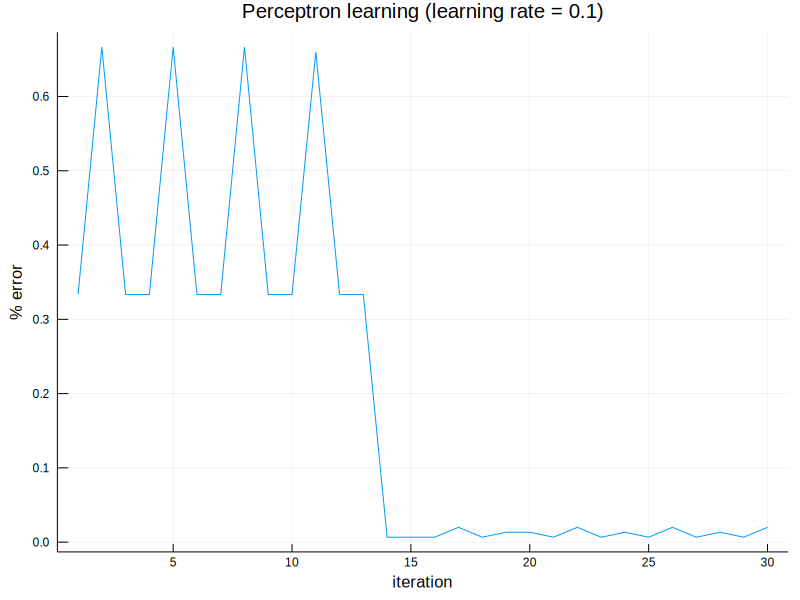

In [22]:
plot(errors, xlabel="iteration", ylabel="% error", legend=:none, 
title="Perceptron learning (learning rate = $η)")

### loop with learning rate η = 0.001
Let's see what happens when we make the learning rate smaller.

In [23]:
# loop η = .001
epochs = 30
w = rand(3).-0.5
η = 0.001
errors = Float64[]
weights = Array{Float64}(undef,epochs,3)
for i in 1:epochs
    output = [o >= 0 ? 1 : -1 for o in X*w]
    delta = η*(target.-output)
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[i,:] = w
    push!(errors, count(x->x!=0, delta)/150)
end
errors

30-element Array{Float64,1}:
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 ⋮                   
 0.26                
 0.3333333333333333  
 0.6133333333333333  
 0.3333333333333333  
 0.3333333333333333  
 0.37333333333333335 
 0.3333333333333333  
 0.013333333333333334
 0.006666666666666667
 0.006666666666666667
 0.006666666666666667
 0.013333333333333334

As we expect, it takes longer to drop to find a set of solutions with lower learning rate

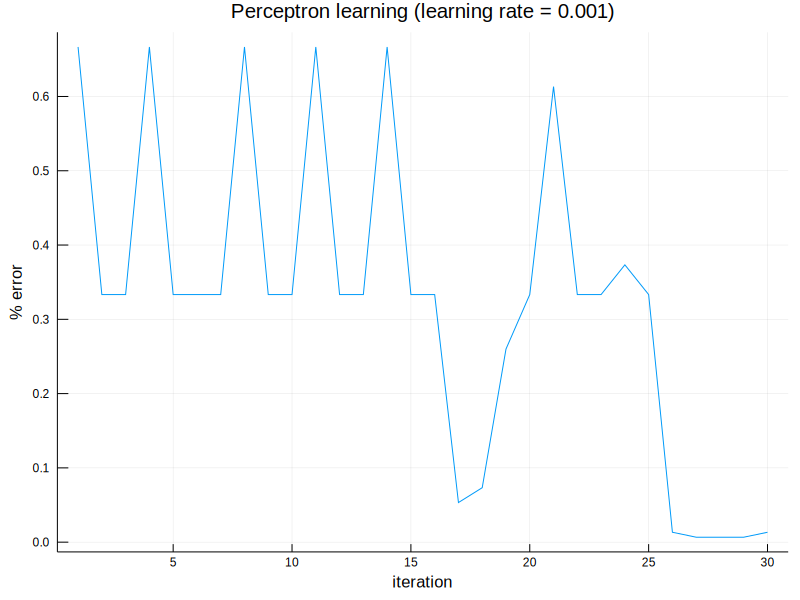

In [24]:
plot(errors, xlabel="iteration", ylabel="% error", legend=:none, 
title="Perceptron learning (learning rate = $η)")

Need to actually go out to 50 epochs

In [25]:
# loop η = .001
epochs = 50
w = rand(3).-0.5
η = 0.001
errors = Float64[]
weights = Array{Float64}(undef,epochs,3)
for i in 1:epochs
    output = [o >= 0 ? 1 : -1 for o in X*w]
    delta = η*(target.-output)
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[i,:] = w
    push!(errors, count(x->x!=0, delta)/150)
end
errors

50-element Array{Float64,1}:
 0.3333333333333333  
 0.6866666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 ⋮                   
 0.3333333333333333  
 0.26666666666666666 
 0.38                
 0.3333333333333333  
 0.02666666666666667 
 0.013333333333333334
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667
 0.013333333333333334
 0.013333333333333334

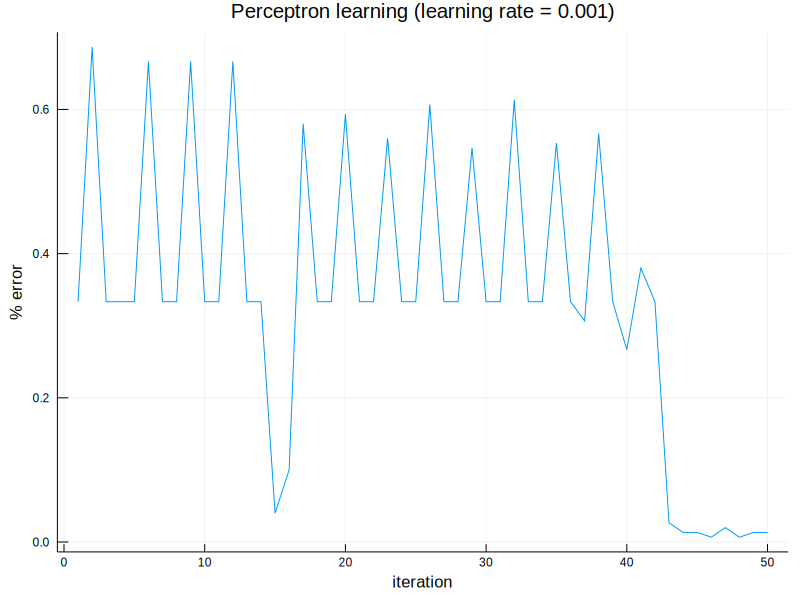

In [26]:
plot(errors, xlabel="iteration", ylabel="% error", legend=:none, 
title="Perceptron learning (learning rate = $η)")

### loop with learning rate η = 0.01

In [40]:
# loop η = .01
epochs = 30
w = rand(3).-0.5
η = 0.01
errors = Float64[]
weights = Array{Float64}(undef,epochs,3)
for i in 1:epochs
    output = [o >= 0 ? 1 : -1 for o in X*w]
    delta = η*(target.-output)
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[i,:] = w
    push!(errors, count(x->x!=0, delta)/150)
end
errors

30-element Array{Float64,1}:
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 ⋮                   
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667

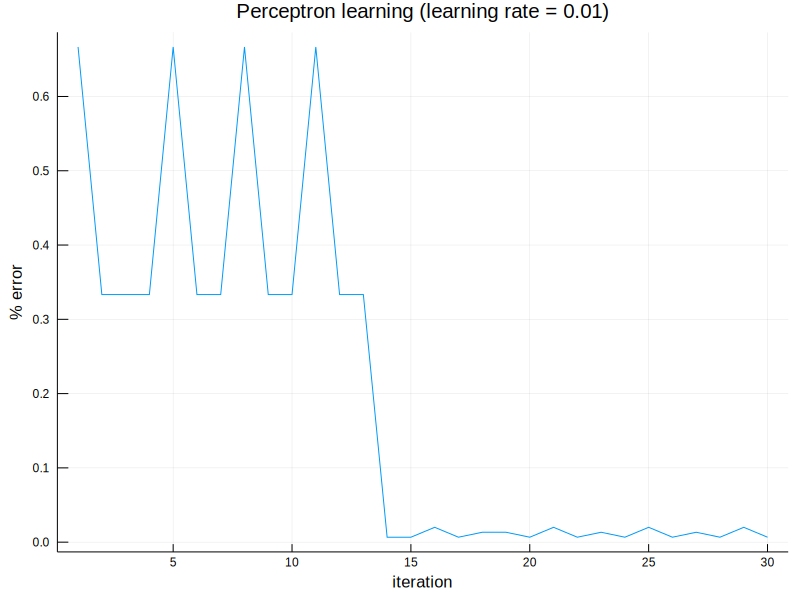

In [41]:
plot(errors, xlabel="iteration", ylabel="% error", legend=:none, 
title="Perceptron learning (learning rate = $η)")

### Identify decision boundary

To visualize the solutions that we come up with, let's plot the decision boundary.  If we are plotting sepal length vs sepal width, we can find out what line would be generated by the weights we calculated using the formula:

$ x_2 = \frac{-w_1}{w_2} x_1 - \frac{w_0}{w_2}$

since we are looking for the place where 

$ w_2 x_2 + w_1 x_1 + w_0 = 0$

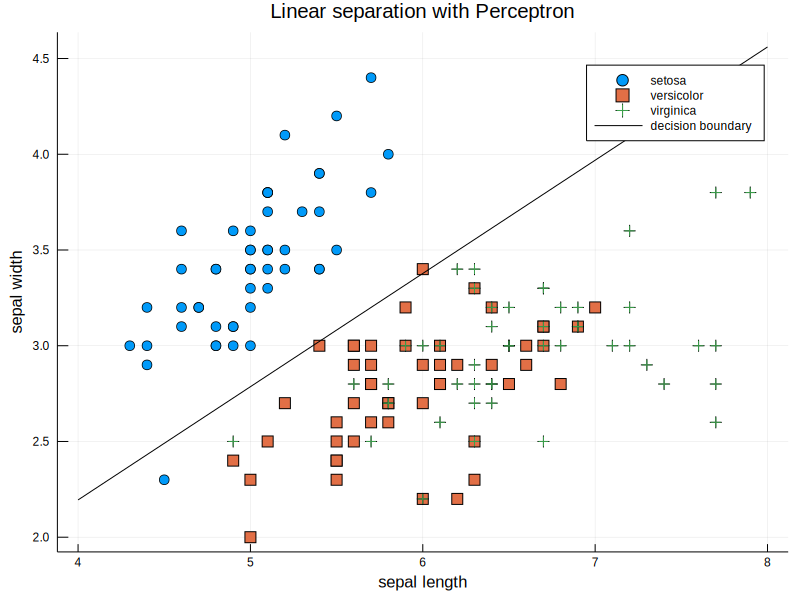

In [42]:
# in Julia, plot! modifies a previous plot
@df iris scatter(:SepalLength, :SepalWidth, group=:Species, title = "Linear separation with Perceptron", 
xlabel = "sepal length", ylabel = "sepal width", marker=([:circle :rect :cross], 5))
x = LinRange(4.0, 8.0, 50)
y = (-w[1]*x.-w[3])/w[2]
plot!(x,y, linecolor=:black, label="decision boundary")

The line above was calculated with the weights we got at the end of all iterations.  If we plot a few other lines from our saved weights (iterations =5, =10, =15 and =20), we can get a feel for how the solutions evolve in the learning process.  Note that when iterations = 5, the line doesn't show up in the plot below because it is not even in the chosen x and y limits.

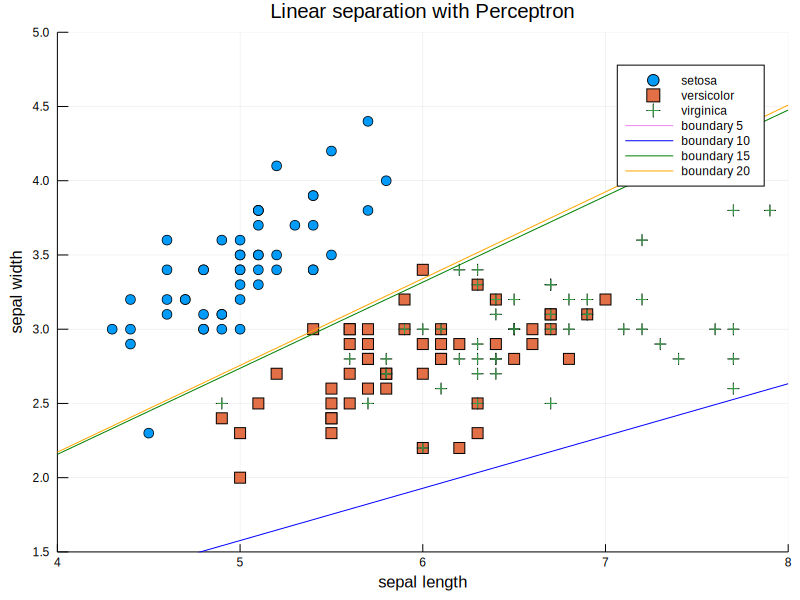

In [44]:
# draw boundaries at different numbers of iterations (note #5 isn't even in the plot frame)
xmin=4
xmax=8
ymin=1.5
ymax=5
@df iris scatter(:SepalLength, :SepalWidth, group=:Species, title = "Linear separation with Perceptron", 
xlabel = "sepal length", ylabel = "sepal width", marker=([:circle :rect :cross], 5))
x = LinRange(4.0, 8.0, 50)
i=5
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))
i=10
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))
i=15
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))
i=20
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))


# Adaline

The **ADA**pative **LI**near **NE**uron, developed by Widrow and Hoff (1960), uses a **linear activation function** to provide a graded feedback compared to Rosenblatt's original perceptron.  The weights are changed using the rule:

update weights ($w_j$) for data at $j$,
$$\quad \Delta w_j = \eta \,(target^{(j)} - output^{(j)}) \,x_i^{(j)}$$

Unlike the perceptron, this output is the weighted sum *without* squashing.  It is derived from taking the partial derviative of the cost function:

$$\quad J(\mathbf{w}) = \frac{1}{2} \sum\limits_{j}( target^{(j)} - output^{(j)} )^2$$

so that the update is in the opposite direction of the gradient:

$$\quad \Delta \mathbf{w} = - \eta\,\nabla \, J(\mathbf{w})$$

Thus, the term *gradient descent* for minimizing the cost function.


In [82]:
# loop η = .01
# gradient doesn't descend if use an η like above (it explodes!)
epochs = 50
w = zeros(3)
η = .01
costs = Float64[]
weights = Array{Float64}(undef,epochs,3)
for j in 1:epochs
    delta = η*(target.-(X*w))
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[j,:] = w
    cost = (sum(abs2, target.-(X*w)))/2
    push!(costs, cost)
end
costs

50-element Array{Float64,1}:
 49937.55818118501         
     2.2093328225082913e8  
     9.779747482535187e11  
     4.3290656519212515e15 
     1.916287660023962e19  
     8.48256573408724e22   
     3.754860135779992e26  
     1.6621120403008426e30 
     7.357441647927458e33  
     3.256817006924492e37  
     1.4416501719154638e41 
     6.381553565229442e44  
     2.824834117127312e48  
     ⋮                     
     1.7730572229072069e143
     7.848547354012847e146 
     3.4742079822544974e150
     1.5378796303993234e154
     6.807519209205229e157 
     3.0133904414654984e161
     1.3338958985876689e165
     5.904572616231212e168 
     2.6136955527985012e172
     1.1569684864133356e176
     5.121392493935815e179 
     2.2670160324117676e183

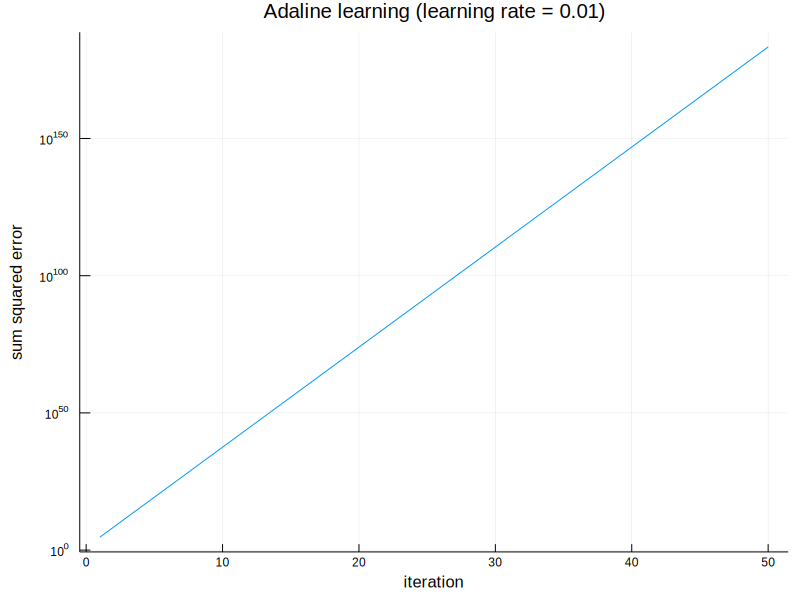

In [84]:
plot(costs, yscale=:log10, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (learning rate = $η)")

In [85]:
# loop η = .0001
# gradient doesn't descend if use an η like above (it explodes!)
epochs = 50
w = zeros(3)
η = .0001
costs = Float64[]
weights = Array{Float64}(undef,epochs,3)
for j in 1:epochs
    delta = η*(target.-(X*w))
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[j,:] = w
    cost = (sum(abs2, target.-(X*w)))/2
    push!(costs, cost)
end
costs

50-element Array{Float64,1}:
 64.42242126811851 
 62.87314628824422 
 62.27989326200292 
 61.791684456524784
 61.318772213762664
 60.851653929937534
 60.38928640371129 
 59.93151858850414 
 59.47829389131015 
 59.02956607943751 
 58.58529041186125 
 58.14542270037576 
 57.70991920670149 
  ⋮                
 47.78520216252389 
 47.45248832708605 
 47.123075499946516
 46.796930927629404
 46.4740221816481  
 46.154317155280665
 45.83778406037723 
 45.524391424198946
 45.21410808628845 
 44.90690319537133 
 44.60274620628829 
 44.30160687695772 

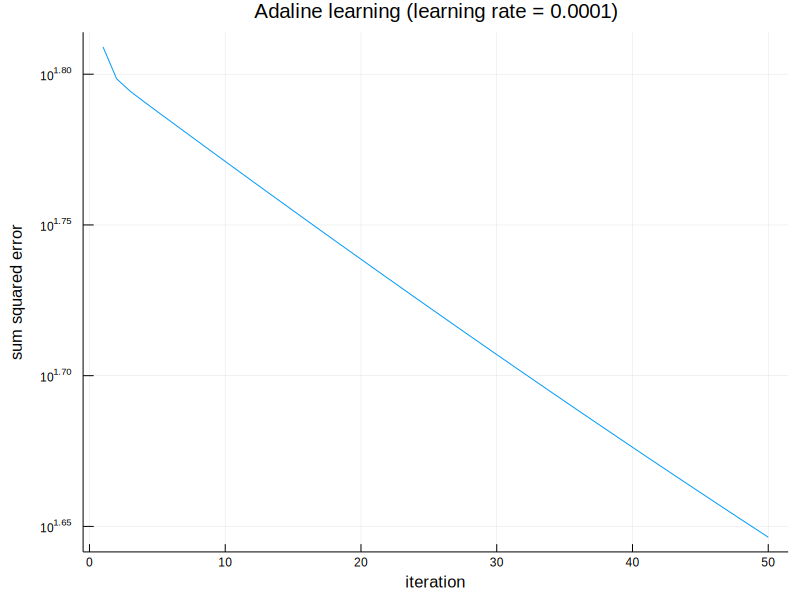

In [86]:
plot(costs, yscale=:log10, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (learning rate = $η)")

In [87]:
weights

50×3 Array{Float64,2}:
 -0.03759    -0.01158     -0.005      
 -0.0520095  -0.0112249   -0.00609918 
 -0.058895   -0.00701519  -0.00593429 
 -0.0633235  -0.00157442  -0.00536141 
 -0.0669434   0.00424576  -0.00465848 
 -0.0702899   0.0101689   -0.00391572 
 -0.0735369   0.0161055   -0.00316242 
 -0.0767408   0.0220264   -0.00240807 
 -0.0799201   0.0279223   -0.00165574 
 -0.0830807   0.0337903   -0.000906422
 -0.0862248   0.0396295   -0.000160421
 -0.0893529   0.0454399    0.000582174
 -0.0924653   0.0512213    0.00132135 
  ⋮                                   
 -0.168181    0.191839     0.0193871  
 -0.170902    0.196891     0.0200396  
 -0.173609    0.201918     0.0206892  
 -0.176303    0.20692      0.0213357  
 -0.178984    0.211897     0.0219793  
 -0.181651    0.21685      0.0226199  
 -0.184305    0.221777     0.0232576  
 -0.186946    0.22668      0.0238924  
 -0.189574    0.231559     0.0245242  
 -0.192188    0.236413     0.0251532  
 -0.19479     0.241243     0.0257793  
 -

We can start the process in a better range if we normalize the input data around zero.  This will help the process zero in faster.

In [89]:
# scale data
Xs = Array{Float64}(undef, 150,3)
for i in 1:2
    Xs[:,i] = convert(Array, X[:,i].-mean(X[:,i]))./std(X[:,i]);
end
Xs[:,3] = ones(150);

UndefVarError: UndefVarError: mean not defined

In [29]:
# loop with scaling data η = .001
epochs = 20
w = zeros(3)
η = .001
costs = Float64[]
weights = Array{Float64}(epochs,3)
for i in 1:epochs
    delta = η*(target.-(Xs*w))
    w += cumsum(Xs.*delta)[end,:]
    weights[i,:] = w
    cost = (sum(abs2,(target.-(Xs*w))))/2
    push!(costs, cost)
end
costs

20-element Array{Float64,1}:
 56.6816
 43.8844
 34.9424
 28.6928
 24.3239
 21.269 
 19.1324
 17.6376
 16.5916
 15.8594
 15.3468
 14.9877
 14.7361
 14.5598
 14.4362
 14.3495
 14.2887
 14.2461
 14.2161
 14.195 


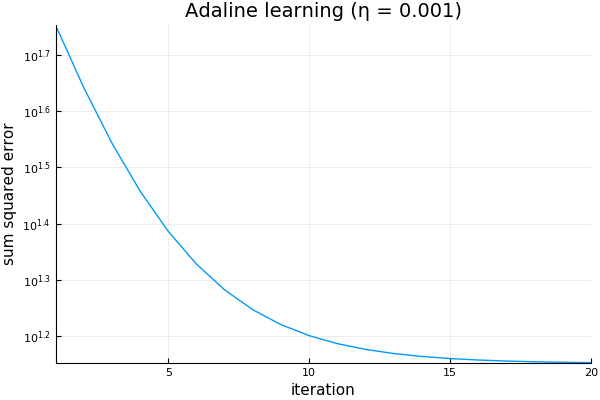

In [30]:
plot(costs, yscale=:log10, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (η = $η)")

In [31]:
# loop with scaling data η = .01
epochs = 20
w = zeros(3)
η = .01
costs = Float64[]
weights = Array{Float64}(epochs,3)
for i in 1:epochs
    delta = η*(target.-(Xs*w))
    w += cumsum(Xs.*delta)[end,:]
    weights[i,:] = w
    cost = (sum(abs2,(target.-(Xs*w))))/2
    push!(costs, cost)
end
costs

20-element Array{Float64,1}:
 39.2985
 24.8569
 18.7828
 16.1719
 15.0356
 14.5376
 14.3184
 14.2217
 14.179 
 14.1601
 14.1517
 14.148 
 14.1464
 14.1457
 14.1454
 14.1452
 14.1452
 14.1451
 14.1451
 14.1451


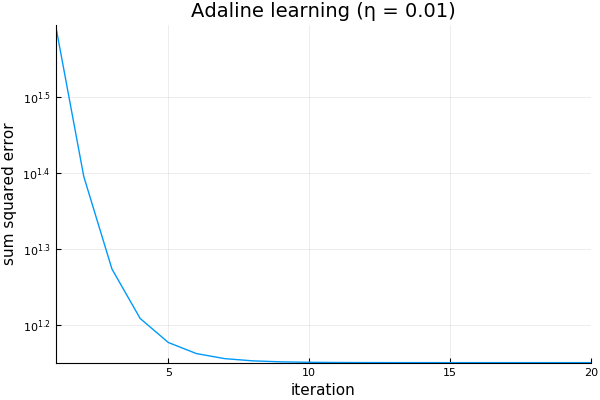

In [32]:
plot(costs, yscale=:log10, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (η = $η)")


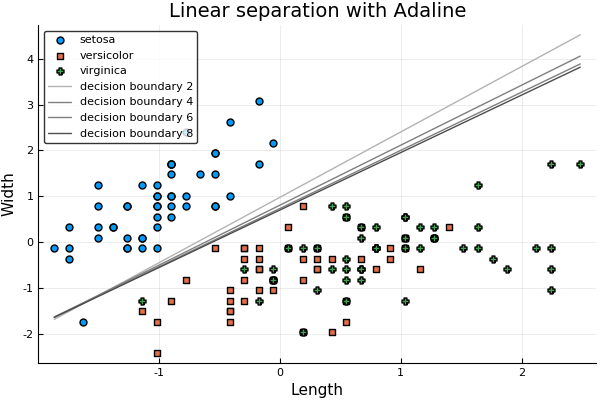

In [33]:
scatter(Xs[:,1],Xs[:,2], group=iris[:Species], title = "Linear separation with Adaline", 
xlabel = "Length", ylabel = "Width", marker=([:circle :rect :cross], 5))

x=linspace(minimum(Xs[:,1]),maximum(Xs[:,1]),50)
i=2
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,4)+1], 
label="decision boundary $i")
i=4
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,4)+1], 
label="decision boundary $i")
i=6
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,4)+1], 
label="decision boundary $i")
i=8
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,4)+1], 
label="decision boundary $i")

In [34]:
weights

20×3 Array{Float64,2}:
 -1.01119   0.850414  -0.5     
 -0.366733  0.256572  -0.25    
 -0.786546  0.66045   -0.375   
 -0.510087  0.389007  -0.3125  
 -0.693103  0.570444  -0.34375 
 -0.571641  0.449479  -0.328125
 -0.652348  0.530029  -0.335937
 -0.598691  0.476422  -0.332031
 -0.634374  0.512089  -0.333984
 -0.610641  0.488361  -0.333008
 -0.626427  0.504145  -0.333496
 -0.615927  0.493646  -0.333252
 -0.622911  0.50063   -0.333374
 -0.618265  0.495984  -0.333313
 -0.621355  0.499074  -0.333344
 -0.6193    0.497019  -0.333328
 -0.620667  0.498386  -0.333336
 -0.619758  0.497477  -0.333332
 -0.620363  0.498082  -0.333334
 -0.61996   0.497679  -0.333333


[<img style="float: left;" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png">](http://creativecommons.org/licenses/by-sa/4.0/)  

Licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).